## Frequencies here used for the features can be varied as a hyperparameter

In [9]:
import scipy.io
import numpy as np
import networkx as nx
import pickle
from sklearn.preprocessing import StandardScaler

features = np.zeros((152,1395))

for sub in range(1,153):
    filename = "resting_eeg_fconn_"+str(sub).zfill(4)+'.mat'
    
    try:
        mat_data = scipy.io.loadmat('../fconn_test_data/'+filename)
    except:
        continue

    full_data = mat_data["fconn"]

    if(full_data.shape==(30,30,17)):
        pass
    else:
        continue

    # print(full_data[:,:,[0,1,2]].shape)
    freqs = [0,1,2] # Vary this as a hyperparameter!
    data = full_data[:,:,freqs]
    n = data.shape[0]

    data_final = np.zeros((int(n*(n+1)/2),len(freqs))) # (465,3)

    for k in range(len(freqs)):
        d = 0
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if(j>=i):
                    data_final[d,k] = data[i,j,k]
                    # print(d,i,j)
                    d+=1

    data_final = data_final.flatten()
    features[sub-1] = data_final


print(features.shape)
np.savetxt('features.csv', features, delimiter=',')

(152, 1395)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = np.loadtxt('features.csv', delimiter=',')

print(data.shape)

(152, 1395)


In [13]:
data_info = pd.read_csv('data_info.csv',usecols=[0,1])
data_info = data_info.loc[:120]
data_filt = data_info.dropna()

labels = data_filt.values[:,1]
y = labels

dfX = pd.DataFrame(data)
subjects_list = data_filt['BASIC_INFO_ID'].unique().tolist()
sub_nums = [int(subject.split('-')[1]) for subject in subjects_list]
print(sub_nums)

arr = np.array(sub_nums)
existing_indices = arr - 1
dfXExisting = dfX.loc[existing_indices]
X = dfXExisting.values

X.shape,y.shape

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 34, 35, 36, 38, 39, 43, 44, 45, 46, 47, 49, 50, 52, 55, 56, 57, 58, 59, 60, 63, 64, 65, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 100, 101, 103, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 123, 126, 127, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152]


((118, 1395), (118,))

In [17]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train1, X_test1, y_train1, y_test1, indices_train, indices_test = train_test_split(X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)
print("Training set size:", X_train1.shape)
print("Testing set size:", X_test1.shape)

Training set size: (94, 1395)
Testing set size: (24, 1395)


In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import time

# Labels are stored in the variable 'labels'
# Rest of the data features are stored in 'X'
sigmas = 3
min_split = [10,20,40,50]
max_depths = [3,5,8,12]
n_estimators = 10
k = 4 # 0 means no augmentation

start = time.time()

tr_errors = []
errors = []
times = []
fimps = []

for m in min_split:
    # print("sigma = ",sigma)
    print("min_samples_split = ",m)
    for d in max_depths:
        print("max_depth = ",d)
        rfgs = RandomForestRegressor(n_estimators=n_estimators,max_depth=d,min_samples_split=m)
        kf = KFold(n_splits=8, shuffle=True)

        fold_errors = []
        fold_tr_errors = []
        fold_fimps = []
        
        for train_index, val_index in kf.split(X_train1):
            X_train2, X_val2 = X_train1[train_index], X_train1[val_index]
            y_train2, y_val2 = y_train1[train_index], y_train1[val_index]

            X_aug = []
            y_aug = []

            X_aug.append(X_train2)
            y_aug.append(y_train2)

            for _ in range(k):
                noisex = np.random.normal(loc=0, scale=sigmas, size=X_train2.shape)
                noisey = np.random.normal(loc=0, scale=sigmas, size=y_train2.shape)
                X_aug.append(X_train2 + noisex)
                y_aug.append(y_train2 + noisey)

            X_aug = np.concatenate(X_aug, axis=0)
            y_aug = np.concatenate(y_aug, axis=0)
            
            rfgs.fit(X_aug, y_aug)

            # print(rfgs.feature_importances_)
            fold_fimps.append(rfgs.feature_importances_)

            # print("Train error: ",mean_absolute_error(y_aug, rfgs.predict(X_aug)))
            fold_tr_errors.append(mean_absolute_error(y_aug, rfgs.predict(X_aug)))
            
            y_pred = rfgs.predict(X_val2)
            fold_error = mean_absolute_error(y_val2, y_pred)
            
            fold_errors.append(fold_error)
            # print("Validation error: ",fold_error)

        # for i, error in enumerate(fold_errors):
        #     print(f"Iteration {i+1}: Validation Error = {error}")

        avg_val_err = np.mean(fold_errors)
        print("Average validation error: ", avg_val_err)
        print("Median = ", np.median(fold_errors))
        end = time.time()
        print("Time: ",end-start)
        times.append(end-start)
        fimps.append(fold_fimps)
        errors.append((m,d,avg_val_err))
        tr_errors.append((m,d,np.mean(fold_tr_errors)))



min_samples_split =  10
max_depth =  3
Average validation error:  10.175312091168852
Median =  10.204478393829737
Time:  5.896428108215332
max_depth =  5
Average validation error:  9.613674247083946
Median =  9.401492750328384
Time:  14.765964031219482
max_depth =  8
Average validation error:  10.231839240072489
Median =  10.255528217720464
Time:  26.46424698829651
max_depth =  12
Average validation error:  10.114964294433214
Median =  10.350335652849441
Time:  38.862876176834106
min_samples_split =  20
max_depth =  3
Average validation error:  10.141418362905595
Median =  10.467582903648427
Time:  44.64819312095642
max_depth =  5
Average validation error:  9.737200362467922
Median =  9.873861822162105
Time:  53.54811429977417
max_depth =  8
Average validation error:  9.625948094165977
Median =  9.477417927933644
Time:  64.24083304405212
max_depth =  12
Average validation error:  10.273623613220092
Median =  10.137931398555256
Time:  74.85705709457397
min_samples_split =  40
max_depth 

<BarContainer object of 1395 artists>

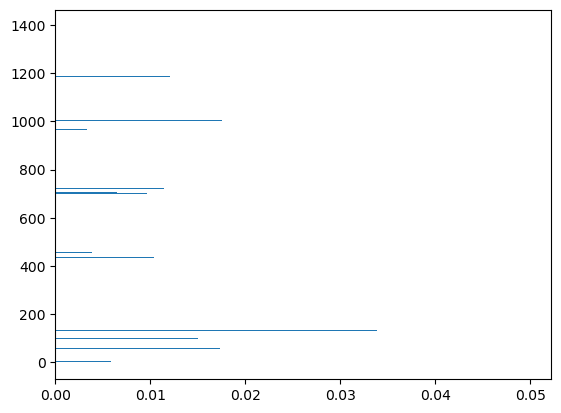

In [31]:
plt.barh(range(X_train1.shape[1]), fold_fimps[0])

In [32]:
errors

[(10, 3, 10.175312091168852),
 (10, 5, 9.613674247083946),
 (10, 8, 10.231839240072489),
 (10, 12, 10.114964294433214),
 (20, 3, 10.141418362905595),
 (20, 5, 9.737200362467922),
 (20, 8, 9.625948094165977),
 (20, 12, 10.273623613220092),
 (40, 3, 9.735657932144168),
 (40, 5, 9.925060086115197),
 (40, 8, 9.456725251236207),
 (40, 12, 10.010936765875433),
 (50, 3, 10.053931599552586),
 (50, 5, 10.285097818250158),
 (50, 8, 9.565782297653069),
 (50, 12, 9.502041352642653)]

In [27]:
tr_errors

[(10, 3, 8.392451435301613),
 (10, 5, 6.650530837106743),
 (10, 8, 4.93719843244516),
 (10, 12, 4.734638607086649),
 (20, 3, 8.513536578134325),
 (20, 5, 6.810280771342357),
 (20, 8, 5.86342678140706),
 (20, 12, 5.7106597657187566),
 (40, 3, 8.623434004593939),
 (40, 5, 7.453284492529486),
 (40, 8, 7.0972738312133465),
 (40, 12, 7.048033335668806),
 (50, 3, 8.741151587030602),
 (50, 5, 7.744167246152039),
 (50, 8, 7.493912570818326),
 (50, 12, 7.5143919808876785)]